In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt



import os
os.chdir("D:/Documents/Ml_electiv_Orehov/bbc-fulltext/bbc")
import math
import string

from sklearn.cluster import DBSCAN
from sklearn.cluster import OPTICS
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics.cluster import v_measure_score

from scipy.cluster.hierarchy import dendrogram, linkage, fcluster

In [2]:
import nltk 
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

#nltk.download("stopwords")
#nltk.download("wordnet")

In [3]:
directories = ["business", "entertainment", "politics", "sport", "tech" ]

path = "D:/Documents/Ml_electiv_Orehov/bbc-fulltext/bbc"
path_filtred = "D:/Documents/Ml_electiv_Orehov/bbc_preprocesed"

#for folder in directories:
#    os.mkdir(path_filtred + "/" + folder)

## Data preprocessing

In [4]:
stop_words = set(stopwords.words('english'))  


for curr_dir in directories:
    files_name = os.listdir(curr_dir)
    for file in files_name:
        
        file1 = open(path + "/" + curr_dir + "/" + file)  
        # Use this to read file content as a stream:  
        appendFile = open(path_filtred + "/" + curr_dir + "/" + file,'w') 

        line = file1.read().lower().translate(str.maketrans('', '', string.punctuation))
        words = line.split()  
        for r in words:  
            if not r in stop_words:  
                lemmatizer = WordNetLemmatizer()
                r = lemmatizer.lemmatize(r)
                appendFile.write(" "+r)  
        appendFile.close()  

In [5]:
words_or = []
words_pre = []

for curr_dir in directories:
    files_name = os.listdir(curr_dir)
    for file in files_name:
        
        file_check_orig = open(path + "/" + curr_dir + "/" + file)  
        file_check_pre = open(path_filtred + "/" + curr_dir + "/" + file) 

        line1 = file_check_orig.read() 
        words1 = line1.split()  

        line2 = file_check_pre.read()
        words2 = line2.split() 
        
        words_or.append(len(words1))
        words_pre.append(len(words2))


In [6]:
print(sum(words_or) - sum(words_pre))

358619


In [7]:
def get_sentences_array(path_fold):
    sentences = []
    for curr_dir in directories:
        files_name = os.listdir(curr_dir)
        for file in files_name:
            file_check_pre = open(path_fold + "/" + curr_dir + "/" + file) 
            line = file_check_pre.read() 
            sentences.append(line)
    return sentences


In [8]:
data_preproc = get_sentences_array(path_filtred)
data_raw = get_sentences_array(path)

## Tfid

On raw data

In [9]:
files_list = []

for curr_dir in directories:
    files_list += list(map(lambda x: path + "/" + curr_dir + "/" + x, os.listdir(curr_dir)))

vectorizer = TfidfVectorizer(input = 'filename', encoding = 'windows-1251', stop_words='english')
X = vectorizer.fit_transform(files_list)

On prepoc data

In [10]:
files_list = []

for curr_dir in directories:
    files_list += list(map(lambda x: path_filtred + "/" + curr_dir + "/" + x, os.listdir(curr_dir)))

vectorizer = TfidfVectorizer(input = 'filename', encoding = 'windows-1251', stop_words='english')
X = vectorizer.fit_transform(files_list)

## Universal Sentence Encoder

In [11]:
from sentence_transformers import SentenceTransformer

In [12]:
model = SentenceTransformer('paraphrase-distilroberta-base-v1')
sentence_embeddings = model.encode(data_preproc)

In [13]:
#len(sentence_embeddings)
#sentence_embeddings

## Word to vector

In [14]:
import gensim 
from gensim.models import Word2Vec 
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
import gensim.downloader

from tqdm.notebook import tqdm


In [15]:
model_W2V = gensim.downloader.load("fasttext-wiki-news-subwords-300")

In [16]:
w2v_vectors = np.zeros((len(data_preproc), 768))
i = 0
for text in tqdm(data_preproc):
    w2v_vectors[i, :] = (model.encode(text))
    i+=1

In [17]:
w2v_vectors 

array([[ 0.20961735,  0.75620496,  0.23501317, ...,  0.06317167,
         0.08754514, -0.03970887],
       [ 0.24034563,  0.3765946 ,  0.15452823, ..., -0.08317673,
        -0.00476325,  0.04105883],
       [ 0.3800666 ,  0.26944274,  0.29238385, ..., -0.52327061,
         0.14515676,  0.14745495],
       ...,
       [ 0.35998899,  0.46702167,  0.46871951, ...,  0.19311427,
        -0.12772988, -0.13798027],
       [ 0.26303804,  0.29544628,  0.16251446, ..., -0.11912133,
         0.07830465,  0.11368729],
       [-0.29621089,  0.44417578,  0.44771832, ...,  0.04109643,
        -0.22081825, -0.17244266]])

In [18]:
def get_files_paths_list (path_):
    files_paths = []
    for curr_dir in directories:
        files_name = os.listdir(curr_dir)
        for file in files_name:  
            files_paths.append(path_ + "/" + curr_dir + "/" + file)  
    return files_paths


In [19]:
docs_paths = get_files_paths_list(path_filtred)

## Clustering 

### DBSCAN + OPTICS

In [20]:
clustering_DB_USE = DBSCAN().fit(sentence_embeddings)
clustering_DB_USE.labels_

array([-1, -1, -1, ..., -1, -1, -1], dtype=int64)

In [21]:
clustering_OPTICS_USE = OPTICS().fit(sentence_embeddings)
clustering_OPTICS_USE.labels_

array([-1, -1, -1, ..., -1, -1, -1])

In [22]:
clustering_DB_TFID = DBSCAN().fit(X)
clustering_DB_TFID.labels_

array([-1, -1, -1, ..., -1, -1, -1], dtype=int64)

In [23]:
clustering_OPTICS_TFID = OPTICS().fit(X.toarray())
clustering_OPTICS_TFID.labels_

array([-1, -1, 13, ..., 21, -1, -1])

In [24]:
clustering_DB_W2V = DBSCAN().fit(w2v_vectors)
clustering_OPTICS_W2V = OPTICS().fit(w2v_vectors )

### e2

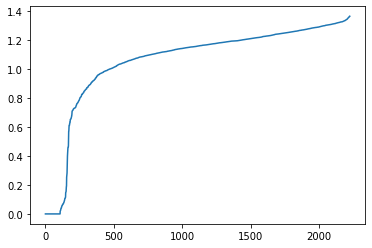

In [25]:
link_TFID = linkage(X.toarray(), 'single', 'euclidean') 
dist_TFID = link_TFID[:, 2]
plt.plot(dist_TFID)

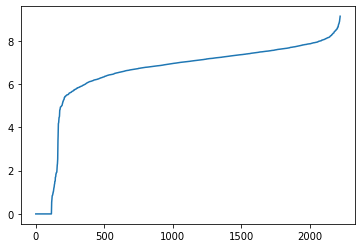

In [26]:
link_W2V = linkage(w2v_vectors, 'single', 'euclidean') 
dist_W2V = link_W2V[:, 2]
plt.plot(dist_W2V)

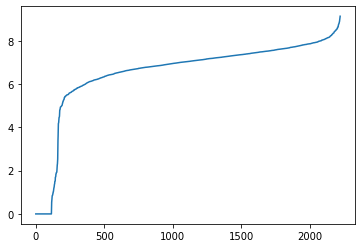

In [27]:
link_USE = linkage(sentence_embeddings, 'single', 'euclidean') 
dist_USE = link_USE[:, 2]
plt.plot(dist_USE)

In [28]:
# Using e2 error func

def clust_linkage (dist):  
    step = 0

    for k in range(20, len(dist)):
        a = 0
        b = 0
        c = 0
        d = 0
        for i in range(k):
            a += (2*i + 1 - k)*dist[i]
            b += (2*k - 1 - 3*i)*dist[i]
            c += (6*i*i - (k - 1)*(2*k - 1))*dist[i]
            d += (3*k*(k - 1) - 1 - 5*i*i)*dist[i]
        a *= 6/(k*(k*k - 1))
        b *= 2/(k*(k + 1))
        c *= 30/(k*(k - 1)*(2*k - 1)*(8*k*k - 3*k - 11))
        d *= 6/(k*(8*k*k - 3*k - 11))

        lin_err = 0
        sqr_err = 0
        for i in range(k):
            lin_err += (a*i + b - dist[i])**2
            sqr_err += (c*i*i + d - dist[i])**2
        if sqr_err < lin_err:
            print(k)
            return k
            
    

In [29]:
num_clusters = []
for i in [dist_TFID, dist_W2V, dist_USE]:
    num_clusters.append(2025 - clust_linkage(i))

num_clusters

109
116
116


[1916, 1909, 1909]

In [30]:
single_clast = {}
for i, j, k in zip([link_TFID, link_W2V, link_USE], ['TFID', 'W2V', 'USE'], num_clusters):
    single_clast[j] = predicted = fcluster(i, t=k, criterion='maxclust')

single_clast

{'TFID': array([1651,  896,  610, ...,  191, 1567, 1437], dtype=int32),
 'W2V': array([ 883,  568,  806, ...,  697,  634, 1647], dtype=int32),
 'USE': array([ 883,  568,  806, ...,  697,  634, 1647], dtype=int32)}

## Results


In [31]:
def get_clusters():
    clusters = []
    for curr_dir in directories:
        files_name = os.listdir(curr_dir)
        for file in files_name:  
            clusters.append(curr_dir)  
    return clusters


In [32]:
from sklearn.metrics.cluster import v_measure_score

clusters = get_clusters()
results = {'TFID' : [v_measure_score(clusters, clustering_DB_TFID.labels_),
                     v_measure_score(clusters, clustering_OPTICS_TFID.labels_),
                     v_measure_score(clusters, single_clast['TFID'])],
           
           'USE' : [v_measure_score(clusters, clustering_DB_USE.labels_),
                    v_measure_score(clusters, clustering_OPTICS_USE.labels_),
                    v_measure_score(clusters, single_clast['USE'])],
           
           'W2V' : [v_measure_score(clusters, clustering_DB_W2V.labels_),
                    v_measure_score(clusters, clustering_OPTICS_W2V.labels_),
                    v_measure_score(clusters, single_clast['W2V'])]
          }

results

{'TFID': [2.0790100803855428e-16, 0.13385604458882788, 0.3521995297490272],
 'USE': [2.0790100803855428e-16, 0.04036886806399674, 0.35276161666503497],
 'W2V': [2.0790100803855428e-16, 0.04036886806399674, 0.35276161666503497]}

In [33]:
from pandas import DataFrame as df

In [34]:
stats = df(data = results, index = ['DB_Scan', 'Optics', 'E_2'])

display(stats)

,TFID,USE,W2V
DB_Scan,2.079010e-16,2.079010e-16,2.079010e-16
Optics,1.338560e-01,4.036887e-02,4.036887e-02
E_2,3.521995e-01,3.527616e-01,3.527616e-01
